### This workbook is about building a predictive model for titanic data - a classic classification problem

The structure of this workbook:

1. Get the data
2. Analysis
3. Wrangle data
4. Model training
5. Try different engineering features
6. Submission
7. References



In [2]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
#from sklearn.utils.fixes import signature
from inspect import signature
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_recall_curve, \
roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, precision_score, make_scorer, f1_score,\
roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, RobustScaler

c:\program files\python37\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\program files\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Get the data

In [3]:
DIR = r"D:\OneDrive - insidemedia.net\project\data-science-project\classification\titanic\titanic"
df_train = pd.read_csv(DIR + '/' + 'train.csv')
df_test = pd.read_csv(DIR + '/' + 'test.csv')
df_combine = [df_train, df_test]

# 2. Analysis

### (1) Overview of all features

In [4]:
# identify different data type of the variables. check numerical variable and categorical variables

print(df_train.info(), '\n')
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None 



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# look at the values in all variables. we can potentially know some values in the categorical variable might need to be adjusted.

for j in range(df_train.shape[1]):
    print(df_train.columns[j])
    print(df_train.iloc[:, j].value_counts())
    print('\n')

PassengerId
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
286    1
285    1
284    1
283    1
282    1
281    1
305    1
307    1
279    1
321    1
      ..
561    1
560    1
584    1
585    1
586    1
587    1
610    1
609    1
608    1
607    1
606    1
605    1
604    1
603    1
602    1
601    1
600    1
599    1
598    1
597    1
596    1
595    1
594    1
593    1
592    1
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64


Survived
0    549
1    342
Name: Survived, dtype: int64


Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64


Name
Cameron, Miss. Clear Annie                             1
Radeff, Mr. Alexander                                  1
Goodwin, Master. William Frederick                     1
Bing, Mr. Lee                                          1
Skoog, Master. Karl Thorsten          

In [6]:
# missing values

def missing_percent(df: pd.DataFrame) -> Dict:
    """Calculate the percentage of the missing data in each columns"""
    percent = {}
    for column_name in list(df.columns):
        percent[column_name] = sum(df[column_name].isnull()) / len(df[column_name])
    return percent

percent = missing_percent(df_train)
percent 


{'PassengerId': 0.0,
 'Survived': 0.0,
 'Pclass': 0.0,
 'Name': 0.0,
 'Sex': 0.0,
 'Age': 0.19865319865319866,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Ticket': 0.0,
 'Fare': 0.0,
 'Cabin': 0.7710437710437711,
 'Embarked': 0.002244668911335578}

In [7]:
percent = missing_percent(df_test)
percent 

{'PassengerId': 0.0,
 'Pclass': 0.0,
 'Name': 0.0,
 'Sex': 0.0,
 'Age': 0.20574162679425836,
 'SibSp': 0.0,
 'Parch': 0.0,
 'Ticket': 0.0,
 'Fare': 0.0023923444976076554,
 'Cabin': 0.7822966507177034,
 'Embarked': 0.0}

### (2) Analyze numerical variables 

In [8]:
# descriptive analysis of the numerical variables

df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# plot the distribution

def plot_numeric(df, feature_list):
    fig, axis = plt.subplots(1, len(feature_list), figsize=(16, 4))
    for i in range(len(feature_list)):
        df[feature_list[i]].plot.hist(ax=axis[i])
        axis[i].set_title(feature_list[i])

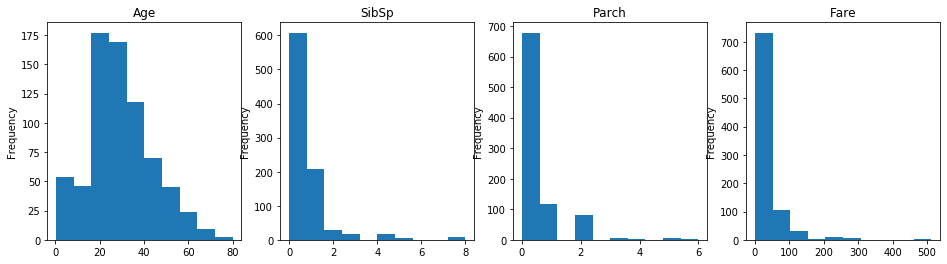

In [10]:
feature_list = ['Age', 'SibSp', 'Parch', 'Fare']
plot_numeric(df_train, feature_list)

### (3) Analyze categorical variables

In [11]:
df_train.describe(include=[np.object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Cameron, Miss. Clear Annie",male,1601,G6,S
freq,1,577,7,4,644


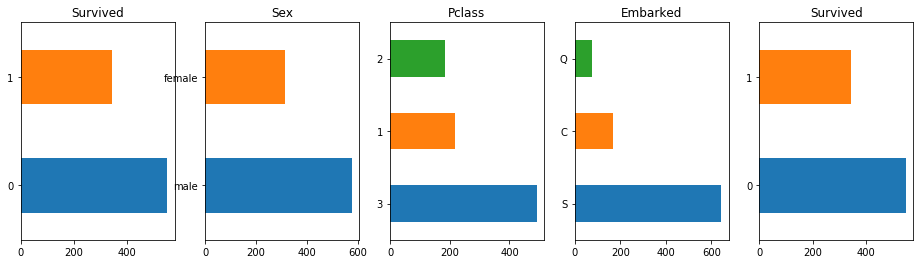

In [12]:
# plot the unique counts for the categorical variables

def plot_categorical(df, categorical_variables_list: List):
    nrows = 1
    ncols = int(np.ceil(len(categorical_variables_list) / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4))

    for i in range(len(categorical_variables_list)):
        df.loc[:, categorical_variables_list[i]].value_counts().plot.barh(ax=axes[i])
        axes[i].set_title(categorical_variables_list[i])

plot_categorical(df_train, ['Survived', 'Sex', 'Pclass','Embarked', 'Survived'])


### (4) Summary

 * Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224). There are 418 samples on the test set. So the training set is 2/3 of the total data available. 

**Which features are available in the dataset?**

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the [Kaggle data page here](https://www.kaggle.com/c/titanic/data).


 **Which features have missing values?**
 * Age, Cabin, and Embarked in the training set, Age, Cabin, and Fare in the test set.


 **What are the numeric variables and categorical variables?**

 * Numerical variables: (1) continuous: 'Age', 'Fare'; (2) discrete: 'SibSp', 'Parch'. 
 * Categorial variables: (1) ordinal: 'Pclass'; (2) nominal: 'PassengerId',  'Name', 'Sex',  'Survived', 'Ticket', 'Cabin', 'Embarked'.


 **What is the distribution of numerical feature values across the samples?**

 * Age: The range of  age is very wide. It is from infant to very old people.
 * SibSp, Parch: From the number of the sibling, parents, and children, we can tell most of the people travel alone. 
 * Fare: Fare vary a lot


 **What is the distribution of categorical features?**

 * Survived: Survived variable is the target variable. 1 means survived. 38% of the people are survived. The data is relatively balanced.
 * Pclass: Lowest class cabinet contains most people, almost 50%.
 * PassengerId: Name of the passenger is unique. it contains the gender information. Mr. Ms. However, it may contain some type  errors.
 * Sex: There are almost twice men than women.
 * Ticket: The format of the ticket number vary a lot. It is a mix of alphanumeric. There are duplicate ticket numbers. They are wrong. 
 * Cabin: cabin name may contain some errors.
 * Embarked: most of the people embarked from S.
 * Survived: less people survive



**Which features are mixed data types?**
  Numerical, alphanumeric data within same feature. These are candidates for correcting goal.
* Ticket: a mix of numeric and alphanumeric data types. 
* Cabin: alphanumeric.


**Which features may contain errors or typos?**
* Name: it may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.



**which feature I should select? preliminary inspection**
* passenger ID, Name, and Ticket ID may not useful because they are kind of unique for each passenger, the model 
might not learn anything. 

* I may also consider dropping 'Cabin' features. 
* I will verify the features selection by some analysis in the following steps.

**the test set(I skip here)**
* The variables have similar property as in the training set. Thus, I assume the model trained on the training set will havea similar performance on the test set



### (5) Analyze correlation between features and target



#### (a) Numerical variable vs. target variable

#### descriptive

In [39]:
df_train.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


#### visulization

###### for 'Age'

mean

C:\Users\music\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


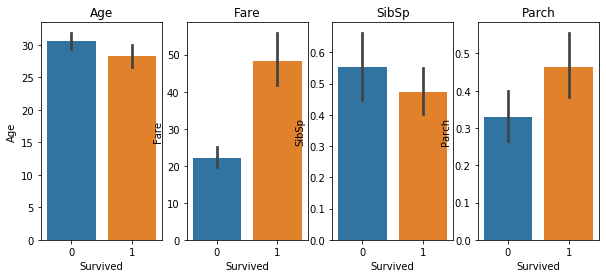

In [15]:
def plot_numerical_target(df, feature_list, target):
    fig, axis = plt.subplots(1, len(feature_list), figsize=(10, 4))
    for i in range(len(feature_list)):
        sns.catplot(ax=axis[i], data=df, x=target, y=feature_list[i], kind='bar')
        axis[i].set_title(feature_list[i])
    
plot_numerical_target(df_train, ['Age', 'Fare', 'SibSp', 'Parch'], 'Survived')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)


distribution 

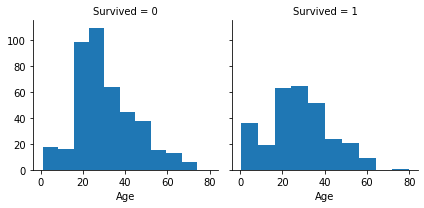

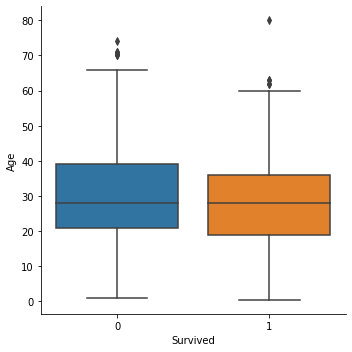

In [16]:
g = sns.FacetGrid(data=df_train, col='Survived')
g.map(plt.hist, 'Age')

sns.catplot(data=df_train, x='Survived', y='Age', kind='box')


two features

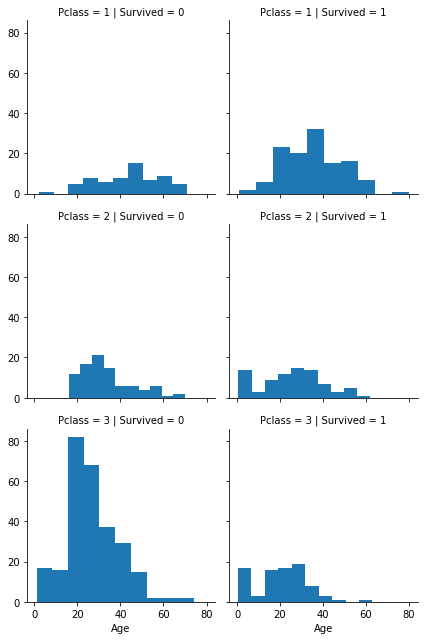

In [17]:
# We can combine multiple features for identifying correlations using a single plot. 
# This can be done with numerical and categorical features which have numeric values.

g = sns.FacetGrid(data=df_train, row='Pclass', col='Survived')
g.map(plt.hist, 'Age')


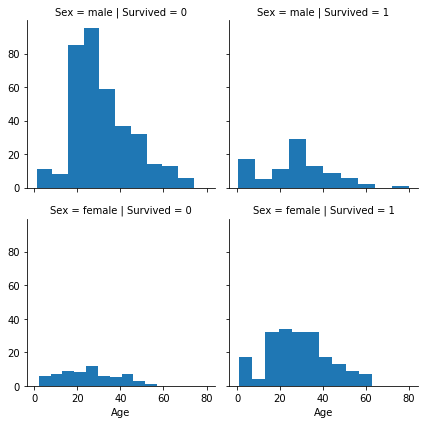

In [18]:
g = sns.FacetGrid(data=df_train, row='Sex', col='Survived')
g.map(plt.hist, 'Age')

**Summary**
* very yonge children and around 80 years old people tend to survive
* most of the people are within 20-40.
* Large number of 15-25 year olds did not survive.
* Thus, Age feature need to be included
* can consider create age category engineering feature: 0-10, 10-20, 20-40, 40-60, 60-80, > 80
* first class cabinet tends to have older people and tend to survive. class 3 is the opposite. should consider Pclass as the feature
* among people who didn't survive, man is dominant. More men die than survive, less women die than survive. Gender should be included into the feature.

##### 'Fare'

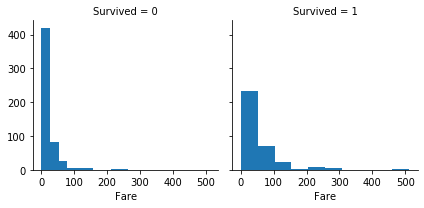

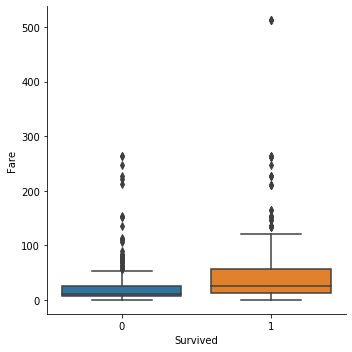

In [19]:
g = sns.FacetGrid(data=df_train, col='Survived')
g.map(plt.hist, 'Fare')

sns.catplot(data=df_train, x='Survived', y='Fare', kind='box')


**Summary**
* Most of the people pay less than 100
* there are more people pay between 200-300 in the Survived group 
* a large number of people who pay less than 50 didn't survive
* Thus, I will include Fare into the feature
* can consider create fare categorical varialbe as a engineering feature. <100, 100-200, > 200

C:\Users\music\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


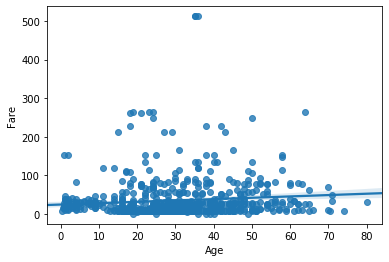

In [20]:
sns.regplot(data=df_train, x='Age', y='Fare')

**Summary**
* most of the people pay fee at the lower range
* people who pay lower fee, they spread across different ages.
* Thus, although people who is yonger and pay higher tend to survive, I cannot say younger people pay higher fee

##### 'SibSp'

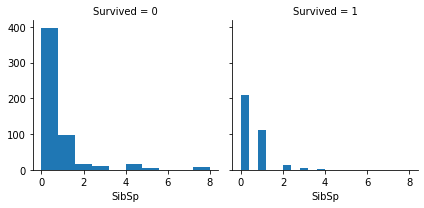

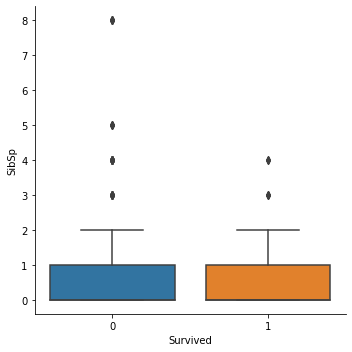

In [21]:
g = sns.FacetGrid(data=df_train, col='Survived')
g.map(plt.hist, 'SibSp')

sns.catplot(data=df_train, x='Survived', y='SibSp', kind='box')

##### Parch

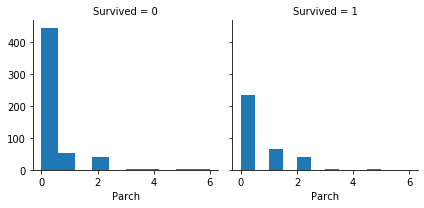

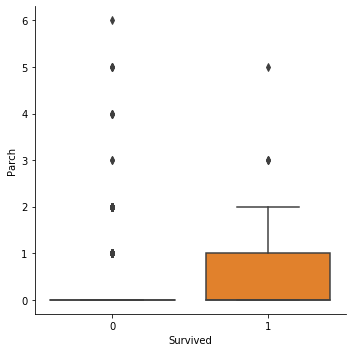

In [22]:
g = sns.FacetGrid(data=df_train, col='Survived')
g.map(plt.hist, 'Parch')
sns.catplot(data=df_train, x='Survived', y='Parch', kind='box')


**Summary**
* People who have less sibling tend to survive, there are less people have have more than 4 sibings
* On the other hand, people who have more parent and children tend to survive.
* SibSp and Parch should be included into the model for further analysis.
* We can consider add SibSp and Parch together to create a engineering feature.

####  (c) Categorical variable vs. target variable

##### descriptive

In [49]:
def cat_target(df, feature, target):
    for i in range(len(feature)):
        print(df.groupby(by=feature[i]).mean().sort_values(by=target, ascending=False), '\n')  

In [50]:
cat_target(df_train, ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'], 'Survived')

        PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        461.597222  0.629630  38.233441  0.416667  0.356481  84.154687
2        445.956522  0.472826  29.877630  0.402174  0.380435  20.662183
3        439.154786  0.242363  25.140620  0.615071  0.393075  13.675550 

        PassengerId  Survived    Pclass        Age     SibSp     Parch  \
Sex                                                                      
female   431.028662  0.742038  2.159236  27.915709  0.694268  0.649682   
male     454.147314  0.188908  2.389948  30.726645  0.429809  0.235702   

             Fare  
Sex                
female  44.479818  
male    25.523893   

       PassengerId  Survived    Pclass        Age     Parch       Fare
SibSp                                                                 
1       439.727273  0.535885  2.057416  30.089727  0.655502  44.147370
2       412.428571  0.464286  2.357143  22.620

**Summary**

* Age vs Survived: Yonger people tend to survive. Since it is only 2 years yonger, it may not be significant.
* Fare vs Survived: people who pay higher fee tend to survive. It may be significant since they pay twice more.
* Age and Fare should be included into the model for further analysis

* Pclass vs Survived, Sex vs Survived: both Pclass and Sex have strong correlation with the survival. We should include them into the model
* SibSp vs Survived, Parch vs Survived, Embarked vs Survived: I am not sure the correlation.  It may be best to derive a feature or a set of features from these individual features.

##### visulization

In [25]:
df_survived = df_train[df_train['Survived'] == 1]
df_notsurvived = df_train[df_train['Survived'] == 0]

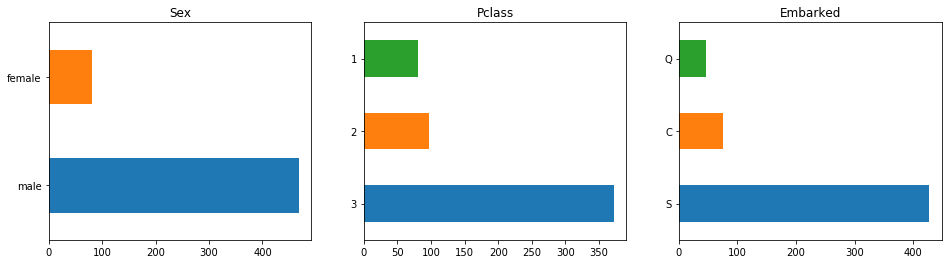

In [26]:
plot_categorical(df_notsurvived, [ 'Sex', 'Pclass','Embarked'])

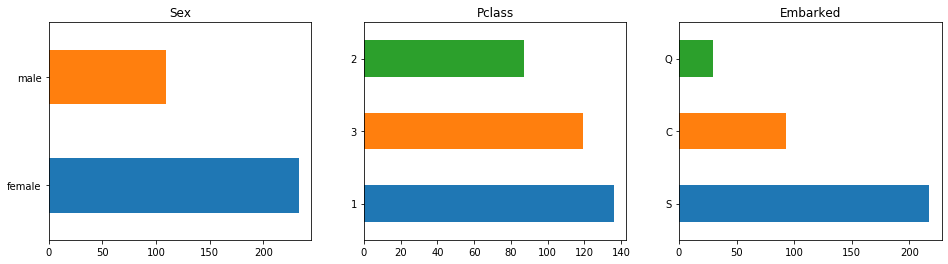

In [27]:
plot_categorical(df_survived, ['Sex', 'Pclass','Embarked'])


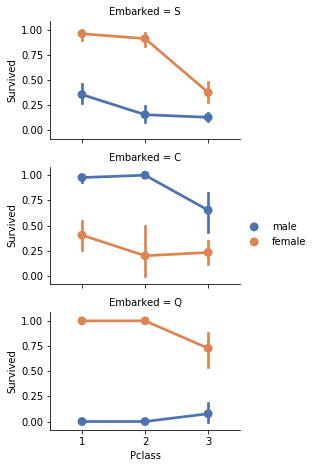

In [36]:
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

**Summary**
* some facotors are favorable to survive. female, higher class, Embarked on C,Q ports
* I will include them into the features

### (6) Assumtions based on data analysis



We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

Since Age and Fare are important, we need to fill the missing value. I also need to complete Embarked. Cabin has a lot of missing value. Since I will drop Cabin feature, don't worry about it.

**Correcting.**
 * we can drop some features.
1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

# 3.  Wrangle data

In [302]:
df_train_ = df_train.copy()
df_test_ = df_test.copy()

###  (1) Drop some columns or remove some categories

In [303]:
df_train_.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df_test_.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True) # keep consistant

print('before', df_train.shape, df_test.shape)
print('after', df_train_.shape, df_test_.shape)

before (891, 12) (418, 11)
after (891, 8) (418, 7)


### (2) missing values

### Completing  numerical features

##### Age

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using [median](https://en.wikipedia.org/wiki/Median) values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

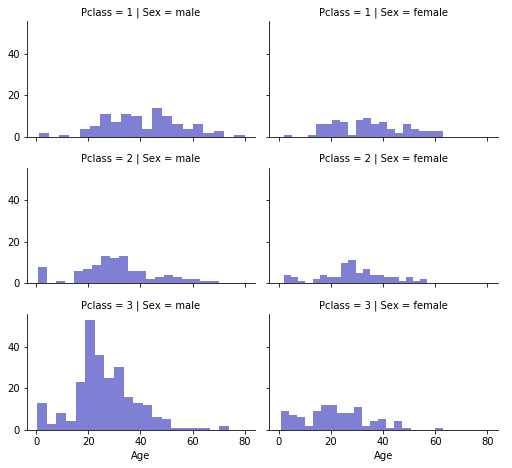

In [304]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(df_train_, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [305]:
#Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.
guess_ages = np.zeros((2,3))
guess_ages
sex_list = ['male', 'female']
df_combine_ = [df_train_, df_test_]

#Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.
for dataset in df_combine_:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == sex_list[i]) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            #print(age_guess)
            guess_ages[i,j] = (age_guess/0.5 + 0.5 ) * 0.5
            #guess_ages[i,j] = int(age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == sex_list[i]) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

df_train_.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.25,S
1,1,1,female,38,1,0,71.28,C
2,1,3,female,26,0,0,7.92,S
3,1,1,female,35,1,0,53.10,S
4,0,3,male,35,0,0,8.05,S


In [306]:
# before, age has missing values in the training set
df_train[df_train.index.isin(df_train[df_train.Age.isnull()].index)].head(5)

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",...,330877,8.46,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",...,244373,13.00,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",...,2649,7.22,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",...,2631,7.22,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",...,330959,7.88,NaN,Q


In [307]:
# after 
df_train_[df_train.index.isin(df_train[df_train.Age.isnull()].index)].head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,25,0,0,8.46,Q
17,1,2,male,30,0,0,13.00,S
19,1,3,female,21,0,0,7.22,C
26,0,3,male,25,0,0,7.22,C
28,1,3,female,21,0,0,7.88,Q


##### Fare
fix missing value in the test set


In [308]:
df_test_['Fare'].fillna(df_test_.Fare.dropna().median(), inplace=True)
df_test_.Fare.isnull().any()

False

### Completing categorical features

In [309]:
freq =  df_train_.Embarked.dropna().mode()[0]
print(freq)

df_train_['Embarked'].fillna(freq, inplace=True)
df_test_['Embarked'].fillna(freq, inplace=True)


S


In [310]:
# before
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.55
1,Q,0.39
2,S,0.34


In [311]:
# after
df_train_[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.55
1,Q,0.39
2,S,0.34


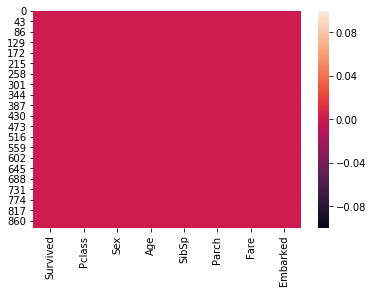

In [312]:
sns.heatmap(df_train_.isnull())

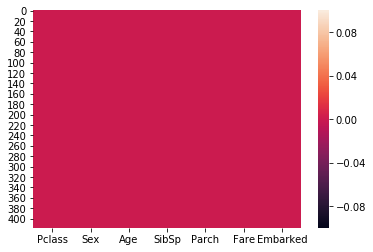

In [313]:
sns.heatmap(df_test_.isnull())

### (3)  Create engineering features

#####  Age

In [314]:
# Let us create Age bands and determine correlations with Survived.
df_train_['AgeBand1'] = pd.cut(df_train_['Age'], bins=5)

print(df_train_[['AgeBand1', 'Survived']].groupby(['AgeBand1'], as_index=False).mean().sort_values(by='AgeBand1', ascending=True))


        AgeBand1  Survived
0  (-0.08, 16.0]      0.55
1   (16.0, 32.0]      0.34
2   (32.0, 48.0]      0.41
3   (48.0, 64.0]      0.43
4   (64.0, 80.0]      0.09


In [315]:
df_train_['AgeBand1'] = pd.cut(df_train_['Age'], bins=5, labels=False)
df_train_.head()

,Survived,Pclass,Sex,Age,...,Parch,Fare,Embarked,AgeBand1
0,0,3,male,22,...,0,7.25,S,1
1,1,1,female,38,...,0,71.28,C,2
2,1,3,female,26,...,0,7.92,S,1
3,1,1,female,35,...,0,53.10,S,2
4,0,3,male,35,...,0,8.05,S,2


In [316]:
# use the same bins as the trainning set
df_test_['AgeBand1'] = pd.cut(df_test_['Age'], bins=[-0.08, 16, 32, 48, 64, 200], labels=False) 
df_train_.head()

,Survived,Pclass,Sex,Age,...,Parch,Fare,Embarked,AgeBand1
0,0,3,male,22,...,0,7.25,S,1
1,1,1,female,38,...,0,71.28,C,2
2,1,3,female,26,...,0,7.92,S,1
3,1,1,female,35,...,0,53.10,S,2
4,0,3,male,35,...,0,8.05,S,2


##### try another bins

In [317]:
bins=[-0.1, 10, 20, 40, 60, 80, 200] 
df_train_['AgeBand2'] = pd.cut(df_train_['Age'], bins=bins)
print(df_train_[['AgeBand2', 'Survived']].groupby(['AgeBand2'], as_index=False).mean().sort_values(by='AgeBand2', ascending=True))


        AgeBand2  Survived
0   (-0.1, 10.0]      0.59
1   (10.0, 20.0]      0.38
2   (20.0, 40.0]      0.36
3   (40.0, 60.0]      0.40
4   (60.0, 80.0]      0.23
5  (80.0, 200.0]       NaN


In [318]:
df_train_['AgeBand2'] = pd.cut(df_train_['Age'], bins=bins, labels=False)
df_test_['AgeBand2'] = pd.cut(df_test_['Age'], bins=bins, labels=False) 


##### Fare

In [319]:
# Let us create Fare bands and determine correlations with Survived.

df_train_['FareBand1'] = pd.qcut(df_train_['Fare'], q=4)
print(df_train_[['FareBand1', 'Survived']].groupby(['FareBand1'], as_index=False).mean().sort_values(by='FareBand1', ascending=True))


         FareBand1  Survived
0   (-0.001, 7.91]      0.20
1   (7.91, 14.454]      0.30
2   (14.454, 31.0]      0.45
3  (31.0, 512.329]      0.58


In [320]:
df_train_['FareBand1'] = pd.qcut(df_train_['Fare'], q=4, labels=False)
df_train_.head()

,Survived,Pclass,Sex,Age,...,Embarked,AgeBand1,AgeBand2,FareBand1
0,0,3,male,22,...,S,1,2,0
1,1,1,female,38,...,C,2,2,3
2,1,3,female,26,...,S,1,2,1
3,1,1,female,35,...,S,2,2,3
4,0,3,male,35,...,S,2,2,1


In [321]:
df_test_['FareBand1'] = pd.cut(df_test_['Fare'], bins=[-0.001, 7.91, 14.454, 31, 100000], labels=False)

##### try another bins

In [322]:
bins = [-0.1, 100, 200, 1000]
df_train_['FareBand2'] = pd.cut(df_train_['Fare'], bins=bins)
print(df_train_[['FareBand2', 'Survived']].groupby(['FareBand2'], as_index=False).mean().sort_values(by='FareBand2', ascending=True))


         FareBand2  Survived
0    (-0.1, 100.0]      0.36
1   (100.0, 200.0]      0.76
2  (200.0, 1000.0]      0.70


In [323]:
df_train_['FareBand2'] = pd.cut(df_train_['Fare'], bins=bins, labels=False)
df_test_['FareBand2'] = pd.cut(df_test_['Fare'], bins=bins, labels=False)

##### Family size

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [324]:
df_train_['FamilySize'] = df_train_['SibSp'] + df_train_['Parch'] + 1
df_test_['FamilySize'] = df_test_['SibSp'] + df_test_['Parch'] + 1

df_train_[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.72
2,3,0.58
1,2,0.55
6,7,0.33
0,1,0.30
4,5,0.20
5,6,0.14
7,8,0.00
8,11,0.00


We can create another feature called IsAlone.

In [325]:
df_combine_ = [df_train_, df_test_]
for dataset in df_combine_:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

df_train_[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.51
1,1,0.30


We can also create an artificial feature combining Pclass and Age.

In [326]:
df_combine_ = [df_train_, df_test_]
for dataset in df_combine_:
    dataset['AgeBand1*Class'] = dataset.AgeBand1 * dataset.Pclass

df_train_.loc[:, ['AgeBand1*Class', 'AgeBand1', 'Pclass']].head(10)

,AgeBand1*Class,AgeBand1,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### (4) Converting a categorical feature

In [327]:
df_combine_ = [df_train_, df_test_]
for dataset in df_combine_:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


### (5) separate features and target

In [328]:
df_train_.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'AgeBand1', 'AgeBand2', 'FareBand1', 'FareBand2',
       'FamilySize', 'IsAlone', 'AgeBand1*Class'],
      dtype='object')

In [329]:
def split_to_features_labels(df: pd.DataFrame, feature_list: List, label_list: List) -> Tuple[pd.DataFrame, pd.Series]:
    """ Split the data into feature matrix and the labels vector"""
    df_features = df[feature_list]
    df_label = df[label_list]
    return df_features, df_label

In [361]:
feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [331]:
label_list = 'Survived'
df_features, df_label = split_to_features_labels(df_train_, feature_list, label_list)

### (6) split into train set and test set


In [332]:
X_trainval, X_test, y_trainval, y_test = train_test_split( df_features, df_label, test_size=0.2, random_state=0)

# 4. Model training

## Logistic regression 

In [333]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.1, 1, 10, 100, 1000],
             'solver': ['liblinear']}
scorer = make_scorer(f1_score)

model_lg = GridSearchCV(estimator=LogisticRegression(), 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)

model_lg.fit(X_trainval, y_trainval)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

###  evaluate the parameters

In [334]:
mean_test_score = model_lg.cv_results_['mean_test_score']
print('mean_test_score for different paramters \n', mean_test_score)
print('best scores \n', model_lg.best_score_)    
print('best estimator \n', model_lg.best_estimator_)
print('best parameters \n', model_lg.best_params_)

mean_test_score for different paramters 
 [0.29  0.392 0.721 0.729 0.728 0.718 0.732 0.733 0.732 0.732 0.732 0.732]
best scores 
 0.7330488219279093
best estimator 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best parameters 
 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [335]:
results = pd.DataFrame(model_lg.cv_results_)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.80e-03,1.17e-03,2.00e-03,1.60e-06,...,0.28,0.29,0.04,12
1,3.60e-03,4.91e-04,2.40e-03,4.89e-04,...,0.44,0.39,0.06,11
2,4.00e-03,6.33e-04,1.80e-03,4.00e-04,...,0.79,0.72,0.05,9
3,3.40e-03,4.89e-04,1.60e-03,4.90e-04,...,0.79,0.73,0.05,7
4,5.00e-03,6.03e-07,1.60e-03,4.90e-04,...,0.79,0.73,0.04,8


[[0.29  0.392 0.721 0.729 0.728 0.718]
 [0.732 0.733 0.732 0.732 0.732 0.732]]


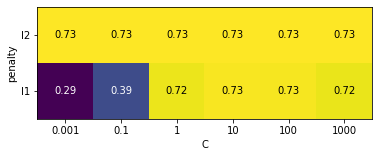

In [336]:
scores = np.array(results.mean_test_score).reshape(2, 6)
print(scores)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. 
This can be done by calculating the coefficient of the features in the decision function. Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [337]:
coeff_df = pd.DataFrame(feature_list)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model_lg.best_estimator_.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.65e+00
6,Embarked,1.83e-01
5,Fare,1.69e-03
4,Parch,-4.78e-02
2,Age,-4.80e-02
3,SibSp,-4.00e-01
0,Pclass,-1.16e+00


**Summary**
* L2 has better performance.
* the model perform similar with different set of regularization
* Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
* Inversely as Pclass increases, probability of Survived=1 decreases the most.
* This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.



### evaluate the performance in the test data set

In [338]:
probs = model_lg.predict_proba(X_test)
predicted = model_lg.predict(X_test)

#### (1) accuracy 

In [339]:
accuracy = accuracy_score(y_test, predicted)
print('accuracy for the test data is: ', accuracy)

accuracy for the test data is:  0.8100558659217877


#### (2) classification report

In [340]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



**summary**
* F1 score for lable 1 is 0.73 in the training set, and 0.75 for the test set. The model generalize well. 

#### (3) precision_recall_curve

In [341]:
def plot_precision_recall_curve(y_test: pd.DataFrame, probability: pd.DataFrame, predicted: pd.DataFrame ):
    """Plot the recall precision tradeoff"""
   
    precision, recall, threshold = precision_recall_curve(y_test, probability)
    #print('precision is', precision)
    #print('recall is', recall)
    
    precision_ = precision_score(y_test, predicted)
    print('precision is ', precision_)
    recall_ = recall_score(y_test, predicted)
    print('recall is', recall_)
    f1 = f1_score(y_test, predicted)
    print('f1 score is', f1)
    
    average_precision = average_precision_score(y_test, probability)
    print('average precision is', average_precision)
    
    # calculate precision-recall AUC (area under the curve)
    auc_ = auc(recall, precision)
    print('precision-recall AUC is', auc_)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                    if 'step' in signature(plt.fill_between).parameters
                    else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))


precision is  0.7692307692307693
recall is 0.7246376811594203
f1 score is 0.7462686567164178
average precision is 0.8479609664270423
precision-recall AUC is 0.8470193875242757


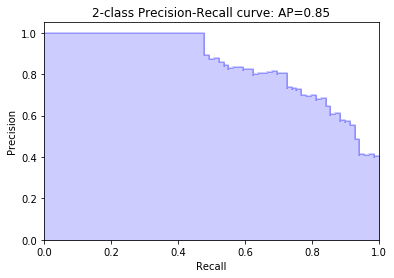

In [342]:
predicted = model_lg.predict(X_test)
plot_precision_recall_curve(y_test, probs[:,1], predicted)

#### (4) ROC curve


In [343]:
def plot_roc_curve(y_test: pd.DataFrame, probability: pd.DataFrame):
    plt.figure()
    fpr, tpr, threshold = roc_curve(y_test, probability)
    roc_auc = auc(tpr, fpr)    # Compute Area Under the Curve (AUC) using the trapezoidal rule
    
    # Plotting
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    print('ROC AUC(area under the curve) is', roc_auc_score(y_test, probability)) 
    print('threshold values :', threshold[0: 20])

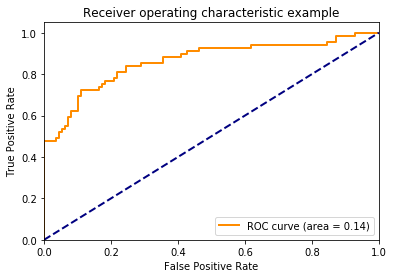

ROC AUC(area under the curve) is 0.8632411067193676
threshold values : [1.968 0.968 0.79  0.784 0.76  0.759 0.754 0.725 0.687 0.683 0.678 0.677
 0.656 0.636 0.636 0.616 0.608 0.564 0.558 0.538]


In [344]:
plot_roc_curve(y_test, np.ravel(probs[:,1]))

## Random Forest

In [345]:
#param_grid = {'n_estimators': [1, 30, 100], 'max_features': ['auto', 'log2'],  
#              'max_depth': [2, 4, 8, 16], 'criterion': ['gini', 'entropy']
#}

param_grid = {'n_estimators': [1, 30, 100, 500, 1000], 'max_features': ['log2'],  
              'max_depth': [8, 16], 'criterion': ['gini']
}

scorer = make_scorer(f1_score)

model_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)

model_rf.fit(X_trainval, y_trainval)


c:\program files\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [346]:
mean_test_score = model_rf.cv_results_['mean_test_score']
print('mean_test_score for different paramters \n', mean_test_score)
print('best scores \n', model_rf.best_score_)    
print('best estimator \n', model_rf.best_estimator_)
print('best parameters \n', model_rf.best_params_)

mean_test_score for different paramters 
 [0.675 0.747 0.754 0.747 0.749 0.659 0.724 0.725 0.726 0.726]
best scores 
 0.754374773459043
best estimator 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best parameters 
 {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}


  param_max_depth param_n_estimators  mean_test_score
0               8                  1             0.67
1               8                 30             0.75
2               8                100             0.75
3               8                500             0.75
4               8               1000             0.75
5              16                  1             0.66
6              16                 30             0.72
7              16                100             0.73
8              16                500             0.73
9              16               1000             0.73
[[0.675 0.747 0.754 0.747 0.749]
 [0.659 0.724 0.725 0.726 0.726]]


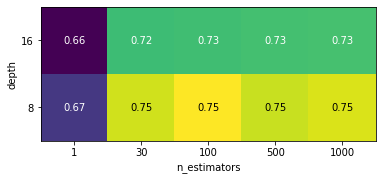

In [347]:
results = pd.DataFrame(model_rf.cv_results_)
print(results[['param_max_depth', 'param_n_estimators', 'mean_test_score']])
scores = np.array(results.mean_test_score).reshape(2, 5)
print(scores)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='n_estimators', xticklabels=param_grid['n_estimators'],
                      ylabel='depth', yticklabels=param_grid['max_depth'], cmap="viridis")

In [348]:
coeff_df = pd.DataFrame(feature_list)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model_rf.best_estimator_.feature_importances_)
coeff_df.sort_values(by='Correlation', ascending=False)


,Feature,Correlation
1,Sex,0.35
5,Fare,0.21
2,Age,0.19
0,Pclass,0.11
3,SibSp,0.06
4,Parch,0.04
6,Embarked,0.04


**Summary**
* the features importance is different from the result from the logistic regresssion. However, Sex is still the number one factor. 

### evaluate the performance in the test data set

In [349]:
probs = model_rf.predict_proba(X_test)
predicted = model_rf.predict(X_test)

#### (1) accuracy 

In [350]:
accuracy = accuracy_score(y_test, predicted)
print('accuracy for the test data is: ', accuracy)

accuracy for the test data is:  0.8379888268156425


In [351]:
accuracy_score(y_test, predicted)

0.8379888268156425

#### (2) classification report

In [352]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       110
           1       0.86      0.70      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



**summary**
* F1 score for lable 1 is 0.75 in the training set, and 0.77 for the test set. The model generalize well. 

#### (3) precision_recall_curve

precision is  0.8571428571428571
recall is 0.6956521739130435
f1 score is 0.7679999999999999
average precision is 0.8716250566820378
precision-recall AUC is 0.8705314747897169


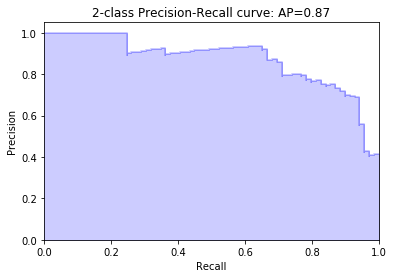

In [353]:
predicted = model_rf.predict(X_test)
plot_precision_recall_curve(y_test, probs[:,1], predicted)

#### (4) ROC curve


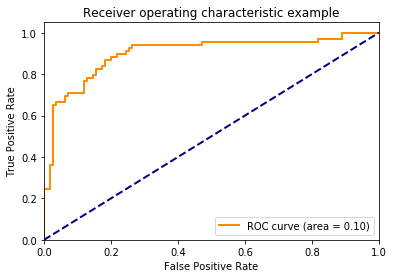

ROC AUC(area under the curve) is 0.9018445322793148
threshold values : [1.995 0.995 0.945 0.941 0.895 0.893 0.605 0.602 0.581 0.564 0.521 0.511
 0.495 0.455 0.423 0.411 0.405 0.395 0.39  0.39 ]


In [354]:
plot_roc_curve(y_test, np.ravel(probs[:,1]))

###  compare logistic regression with random forest

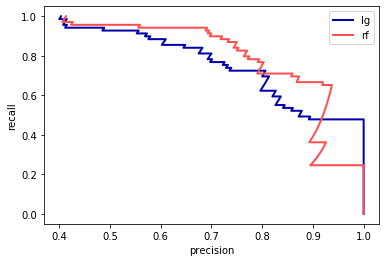

In [355]:
presicion_lg, recall_lg, thresholds_lg = precision_recall_curve(y_test, model_lg.predict_proba(X_test)[:, 1])
plt.plot(presicion_lg, recall_lg, label='lg')

presicion_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
plt.plot(presicion_rf, recall_rf, label='rf')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')

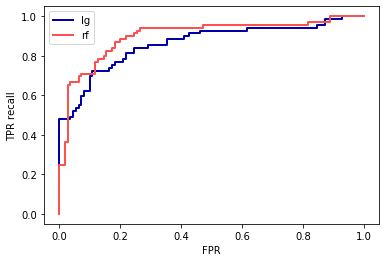

In [356]:
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, model_lg.predict_proba(X_test)[:, 1])
plt.plot(fpr_lg, tpr_lg, label='lg')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='rf')
plt.xlabel('FPR')
plt.ylabel('TPR recall')
plt.legend(loc='best')

**summary**
* For the recall-precision curve, the Area Under the Curve from random forest is larger than the from the logistic regression. Which means with precision increases, the recall drop less in the randome forest.
* for the ROC curve, the curve from random forest is to the upper left of the curve from logistic regression. It means with the same recall, it has less false positive rate.
* As a result, Random forest has better performance than the logistic regression

# 5. Try different engineering features
try different features, then re run the above models again

In [357]:
# add the engineering features
"""
feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'AgeBand1',  'FareBand1' ,
       'FamilySize', 'IsAlone', 'AgeBand1*Class']
"""

In [358]:
# add another  engineering features
"""
feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked',  'AgeBand2',  'FareBand2',
       'FamilySize', 'IsAlone']
"""

In [ ]:
# add the engineering features and drop the original features
"""
feature_list = ['Pclass', 'Sex',
       'Embarked', 'AgeBand1',  'FareBand1' ,
       'FamilySize', 'IsAlone', 'AgeBand1*Class']
"""

**Summary**

(1)  feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

* lg:  F1 score for lable 1 is 0.73 in the training set, and 0.75 for the test set.
* rf:  F1 score for lable 1 is 0.75 in the training set, and 0.77 for the test set.



(2) feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'AgeBand1',  'FareBand1' , 'FamilySize', 'IsAlone', 'AgeBand1*Class'] 
	   
* lg:	F1 score for lable 1 is 0.72 in the training set, and 0.71 for the test set. 
* Rf: 	F1 score for lable 1 is 0.75 in the training set, and 0.77 for the test set. 


(3) feature_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',  'AgeBand2',  'FareBand2', 'FamilySize', 'IsAlone']
	   
* lg: F1 score for lable 1 is 0.75 in the training set, and 0.74 for the test set. 
* rf: F1 score for lable 1 is 0.74 in the training set, and 0.75 for the test set.

(4) feature_list = ['Pclass', 'Sex','Embarked', 'AgeBand1',  'FareBand1' ,'FamilySize', 'IsAlone', 'AgeBand1*Class']

* lg: F1 score for lable 1 is 0.72 in the training set, and 0.75 for the test set.
* rf: F1 score for lable 1 is 0.72 in the training set, and 0.78 for the test set. 


* For logistic regression, if I add the engineering features (features list3) , the f1 score for the training set is the best, however the test set is not. But we don't use test set to influce on the features we choose. Test set is just for evaluate the generalization of the model. 

* for random forest, the original features are good enough, adding the engineering features didn't help or even decrease the perfrmance. If we drop the original features, random forest perform worse.

* Overal, random forest with the original features perform better than the logistic regression model. 

# 6.  Submission

In [362]:
X_test_2 = df_test_[feature_list]
y_test_2 = model_rf.predict(X_test_2)

In [364]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_test_2
    })
submission.to_csv('result.csv', index=False)

# References
* https://www.kaggle.com/c/titanic/overview/tutorials
* https://www.kaggle.com/startupsci/titanic-data-science-solutions
* Introduction to Machine Learning with Python by Sarah Guido, Andreas C. Müller, Publisher: O'Reilly Media, Inc., Release Date: October 2016, ISBN: 9781449369880

